# Step 1. 인물모드 직접 해 보기

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.

- 인물이 주인공이 아닌,귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(512, 526, 3)


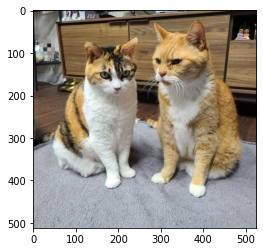

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cats.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0bd5d58250>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

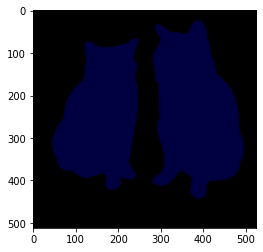

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    print(class_id)

background
0
cat
8


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있습니다. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있습니다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[0]

array([0, 0, 0])

In [12]:
colormap[8]

array([64,  0,  0])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [13]:
seg_color = (0,  0,  64)

seg_color로만 이루어진 마스크를 만들어 봅시다.

(512, 526)


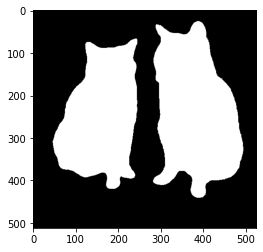

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

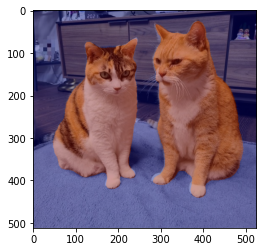

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

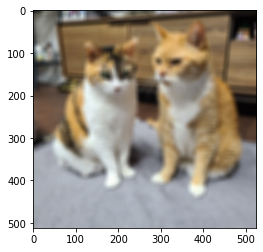

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#img_orig_blur 결과

#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

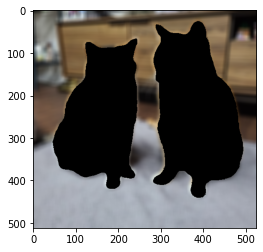

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 됩니다.

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 됩니다.

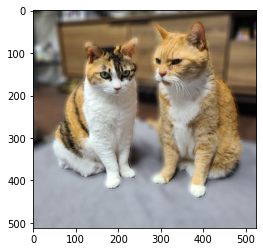

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
#plt.figure(figsize=(100,100))
plt.show()

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠? 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. 
알아야 할 코드 문법: np.where(조건, 참일때, 거짓일때)
참고: https://numpy.org/ (numpy.where) 

자연 배경의 사진과 크로마키 해보겠습니다.

In [19]:
img_path_nature1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/nature1.png'  
img_nature_chromakey = cv2.imread(img_path_nature1) 
img_nature_chromakey = cv2.resize(img_nature_chromakey, (526,512))# 배경사진을 고양이사진 크기와 맞추어준다.

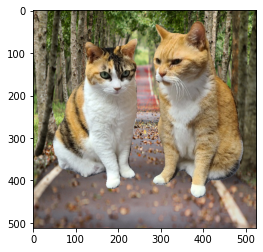

In [20]:
img_concat_cromakey = np.where(img_mask_color==255, img_orig, img_nature_chromakey)
plt.imshow(cv2.cvtColor(img_concat_cromakey, cv2.COLOR_BGR2RGB))
plt.show()

(1050, 700, 3)


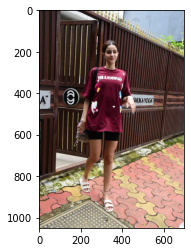

In [21]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/celeb.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

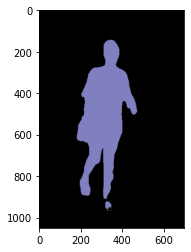

In [22]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    print(class_id)

background
0
person
15


In [24]:
colormap[0]

array([0, 0, 0])

In [25]:
colormap[15]

array([192, 128, 128])

In [26]:
seg_color = (128, 128, 192)

(1050, 700)


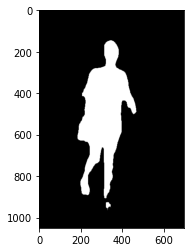

In [27]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

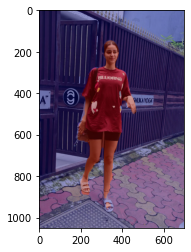

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

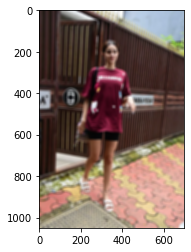

In [29]:
img_orig_blur = cv2.blur(img_orig, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#img_orig_blur 결과

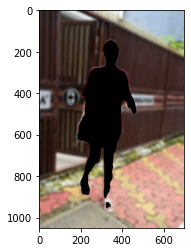

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

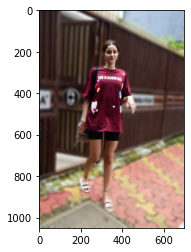

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# Step 2. 사진에서 문제점 찾기

- 아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

- 추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.


(448, 800, 3)


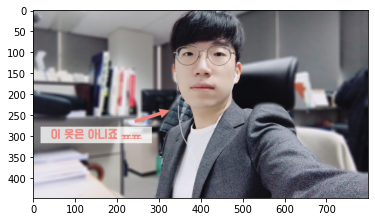

<Figure size 2304x1440 with 0 Axes>

In [32]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/E-14-13.max-800x600.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(32,20))
plt.show()

위 사진의 잘못된 부분은 뒤에 걸린 옷이 blur가 되지않고 나오는 것 외에 인물 자켓의 어깨 부분이 blur처리가 되어 나오는 경우, 또 이어폰 흰색 줄이 배경에 뭍혀서 안나오는 경우 등이 있습니다. 

(727, 900, 3)


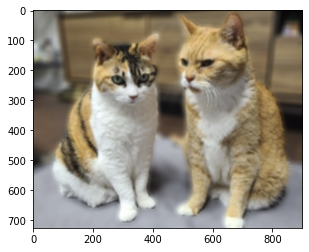

In [33]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/wrong_large.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

위 고양이 사진에서 이상한 점은 고양이 테두리 부분에 희미한 하얀 막이 흔들린 것 처럼나타납니다.아마도 고양이 털이 배경과의 경계에서 그렇게 만든것 같습니다. 
또 오른편 고양이의 왼쪽 수염은 있지만 오른쪽 수염이 안 나타나 있습니다. 

위 여자 사진에서는 손가락 끝부분과 슬리퍼가 person으로 인식되지 않아 배경과 같이 blur처리가 되었습니다. 

# Step 3. 해결 방법을 제안해 보기


구글의 struct2Depth를 이용해 추가적인 depth 정보를 활용하면 위의 문제점들을 보완할수도 있을 것 같습니다. 고양이 수염을 인식 하지 못한 경우 수염과 고양이의 depth가 상대적으로 비슷할 것이고 배경의 depth는 고양이나 수염과 차이가 많이 날것 입니다, 또 사람 손가락 끝부분아나 슬리퍼를 배경으로 인식한 경우, 손가락과 슬리퍼의 depth가 사람의 depth와 비슷하고 배경과는 거리가 있기 때문에 이러한 정보를 이용하면 문제점을 보완할 수 있을 것으로 생각됩니다.